## Crude Oil - LSTM Price Prediction: 10 y - 1d

### Importing Libraries

In [4]:
import tensorflow as tf

2024-03-11 14:34:32.855195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/edo/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/edo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (vers

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Data Setting & Normalizing

In [26]:
data = yf.Ticker('CL').history(period='10y', interval="1d")[['Close', 'Open', 'High','Low','Volume']]

data=data[data['Volume']!=0]
data.isna().sum()
data.reset_index(drop=True, inplace=True)
data.tail()

data = data['Close'].values.reshape(-1, 1)
data

array([[50.11801147],
       [50.06257248],
       [50.07049942],
       ...,
       [88.13999939],
       [88.06999969],
       [87.41500092]])

In [27]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [28]:
# Define function to create dataset
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

### Creating the LSTM Model

In [30]:
time_step = 100

X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [33]:
# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [36]:
# Define the LSTM Model
model = Sequential()
model.add(LSTM(units=64,return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predictions & Inverse
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0285
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.0017
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0015
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 0.0014
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0014
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0013
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.0011
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0011
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0010
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 0.0010
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 8.9439e-04
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0010
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 8.5276e-04
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 8.6323e-04
Epoch 15/100
63/63 ━━━━

### Plotting & Evaluating the model

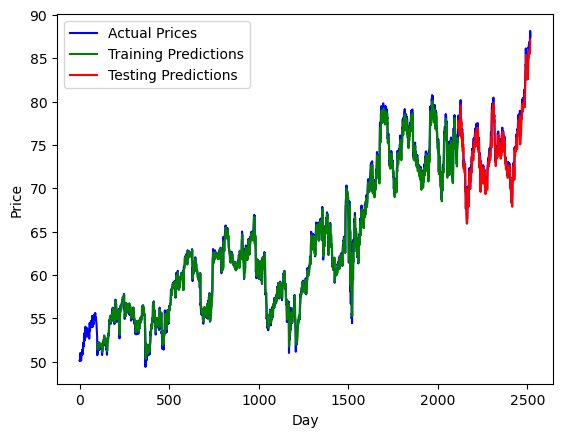

In [53]:
plt.plot(data, color='blue', label='Actual Prices')
plt.plot(np.arange(time_step, len(train_predict) + time_step), train_predict, color='green', label='Training Predictions')
test_range = np.arange(len(train_predict) + time_step, len(train_predict) + time_step + len(test_predict))
plt.plot(test_range, test_predict, color='red', label='Testing Predictions')

plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

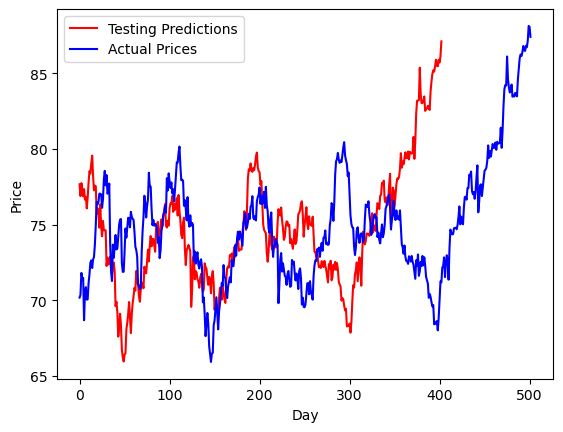

In [72]:
end = len(data)

test_range = np.arange(len(train_predict) + time_step, len(train_predict) + time_step + len(test_predict))
plt.plot(test_predict, color='red', label='Testing Predictions')
plt.plot(data[2016:end], color='blue', label='Actual Prices')

plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, test_predict)
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
r2 = r2_score(y_test, test_predict)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 74.00345562893388
Mean Squared Error (MSE): 5491.248524177331
Root Mean Squared Error (RMSE): 74.10295894346818
Mean Absolute Percentage Error (MAPE): 11427.191121914819
R-squared (R2): -474883.07544333


In [ ]:
# Created by Edoardo Alberto Donolato